In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from itertools import combinations
from mip import Model, OptimizationStatus, maximize, xsum, BINARY
from scripts.assembly import inv_logit, contingency, tetrachoric 
sns.set_theme(style='white', context='notebook', font_scale=1.33)

### Load and prepare data

In [2]:
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = '3pl_m2'

## Ability parameters.
pts = np.array([-1, -0.5, 0, 0.5, 1])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define item information.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit.
params = read_csv(os.path.join('stan_results', f'{stan_model}_summary.tsv'), sep='\t', index_col=0)

## Extract parameters.
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values
gamma = 0.25

## Compute p(correct).
mu = np.outer(alpha, pts) - beta.reshape(-1,1)
p = gamma + (1-gamma) * inv_logit(mu)

## Compute information.
W = np.square(alpha.reshape(-1,1)) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define item functioning.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define ability range.
theta = np.linspace(-3,3,1001)

## Compute p(correct).
mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)

## Weight by prior distribution of abilities. 
prior = norm(0,1).pdf(theta)
P = (prior @ p) / prior.sum()

### Assembly #1

#### Perform optimal test assembly

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define test length.
n_item = 12

## Define TIF tolerance.
dtol = 5e-2

## Define difficulty tolerance.
ptol = 1.0

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Test assembly.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define item triplets.
triples = []
for i in range(0, len(alpha), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
n_triples = len(triples) 

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_triples)]

## Define model objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_triples)) == n_item

## Constraint #2: one triplet per item family.
for i in range(0, n_triples, 6): 
    model += xsum(x[i:i+6]) <= 1
    
## Constraint #3: minimize TIF differences.
for k in range(W.shape[1]):
    model += xsum(x[i] * W[j,k] for i, (j,_,_) in enumerate(triples)) -\
             xsum(x[i] * W[j,k] for i, (_,j,_) in enumerate(triples)) <= dtol
    model += xsum(x[i] * W[j,k] for i, (_,j,_) in enumerate(triples)) -\
             xsum(x[i] * W[j,k] for i, (j,_,_) in enumerate(triples)) <= dtol
    model += xsum(x[i] * W[j,k] for i, (j,_,_) in enumerate(triples)) -\
             xsum(x[i] * W[j,k] for i, (_,_,j) in enumerate(triples)) <= dtol
    model += xsum(x[i] * W[j,k] for i, (_,_,j) in enumerate(triples)) -\
             xsum(x[i] * W[j,k] for i, (j,_,_) in enumerate(triples)) <= dtol
    
## Constraint #4: maximize form difficulty. 
model += xsum(x[i] * P[j] for i, (j,_,_) in enumerate(triples)) / n_item <= ptol
model += xsum(x[i] * P[j] for i, (_,j,_) in enumerate(triples)) / n_item <= ptol
model += xsum(x[i] * P[j] for i, (_,_,j) in enumerate(triples)) / n_item <= ptol
    
## Perform optimization.
status = model.optimize(max_seconds=300)
print('optimal solution: %s' %(status == OptimizationStatus.OPTIMAL))

## Extract selected triplets.
selected = [i for i in range(n_triples) if x[i].x]

## Construct test forms.
items = np.array([triples[i] for i in selected]).T
print(items)

optimal solution: True
[[ 52  95 125 129 149 191 244 253 293 303 334 359]
 [ 53  93 123 130 147 189 245 254 291 304 335 357]
 [ 51  94 124 131 148 190 243 252 292 305 333 358]]


#### Test information

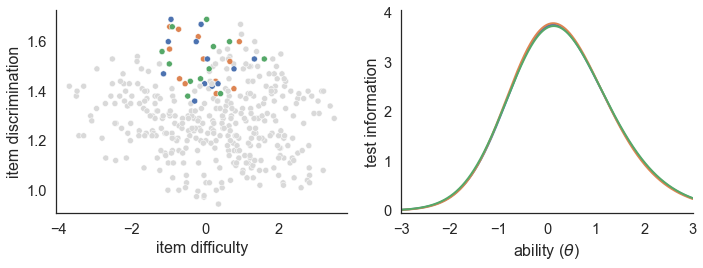

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = ['0.85', '#4c72b0', '#dd8452', '#55a868']

## Define form indicators.
hue = np.zeros_like(alpha)

## Iteratively plot test form information.
for i, ix in enumerate(items):
    
    ## Define indicators.
    hue[ix] = i+1
    
    ## Compute p(correct).
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Compute information.
    I = np.square(alpha[ix]) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))
    
    ## Plot test information.
    axes[1].plot(theta, I.sum(axis=1), lw=2)

## Add detail.
axes[1].set(xlim=(theta.min(), theta.max()), xlabel=r'ability ($\theta$)', 
            ylim=(-0.05, 4.05), ylabel='test information')

## Plot test form indicators.
sns.scatterplot(x=beta, y=alpha, hue=hue, palette=palette, legend=False, ax=axes[0])
axes[0].set(xlabel='item difficulty', ylabel='item discrimination')

sns.despine()
plt.tight_layout()

#### Item functioning

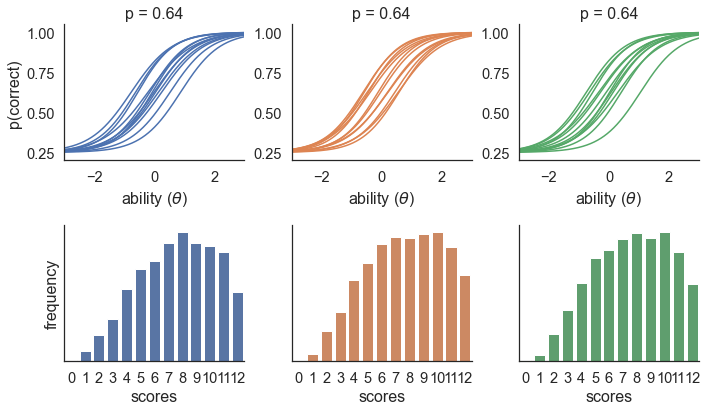

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(2,3,figsize=(10,6))
palette = ['#4c72b0', '#dd8452', '#55a868']

## Iteratively plot.
np.random.seed(47404)
for i, (ix, color) in enumerate(zip(items, palette)):
    
    ## Compute p(correct).
    theta = np.sort(np.random.normal(0,1,5000))
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Simulate scores.
    scores = np.random.binomial(1,p).sum(axis=1)
    
    ## Plot item functioning.
    axes[0,i].plot(theta, p, color=color)    
    axes[0,i].set(xlim=(-3,3), xlabel=r'ability ($\theta$)', ylim=(0.2, 1.05), title='p = %0.2f' %p.mean())
    if not i: axes[0,i].set(ylabel='p(correct)')
    
    ## Plot score distribution.
    sns.countplot(x=scores, order=np.arange(13), color=color, ax=axes[1,i])
    axes[1,i].set(xlabel=r'scores', yticks=[], ylabel='')
    if not i: axes[1,i].set(ylabel='frequency')
    
sns.despine()
plt.tight_layout()

#### Psychometrics

100%|██████████| 1000/1000 [01:09<00:00, 14.37it/s]


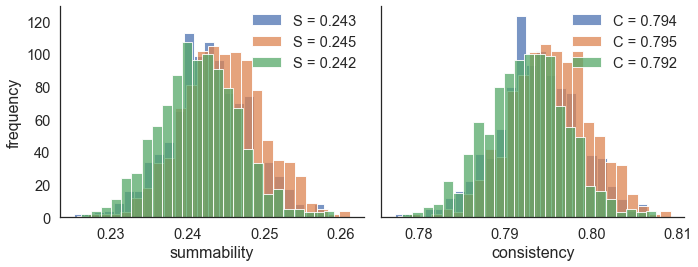

In [6]:
from tqdm import tqdm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
n_samp = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
S = np.zeros((n_samp,3))
C = np.zeros((n_samp,3))

## Main loop.
for i in tqdm(range(n_samp)):
    
    for j, ix in enumerate(items):

        ## Compute p(correct).
        theta = np.sort(np.random.normal(0,1,5000))
        mu = np.outer(theta, alpha[ix]) - beta[ix]
        p = gamma + (1-gamma) * inv_logit(mu)

        ## Simulate accuracy.
        Y = np.random.binomial(1,p)

        ## Compute item standard deviations.
        sigma = np.std(Y, axis=0)

        ## Iteratively compute components of summability.
        a, b = 0, 0
        for k1, k2 in combinations(range(n_item), 2):
            prop = contingency(Y[:,k1], Y[:,k2])       # Compute contingency table.
            rho = tetrachoric(prop)                    # Compute tetrachoric correlation.
            a += rho * sigma[k1] * sigma[k2]           # Compute summability numerator.
            b += sigma[k1] * sigma[k2]                 # Compute summability denominator.

        ## Compute form summability.
        S[i,j] = a / b

        ## Compute form consistency.
        C[i,j] = (n_item * S[i,j]) / (1 + (n_item - 1) * S[i,j])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#    

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
palette = ['#4c72b0', '#dd8452', '#55a868']

## Iteratively plot.
for i, color in enumerate(palette):
    sns.histplot(x=S[:,i], color=color, bins=25, label='S = %0.3f' %S[:,i].mean(), ax=axes[0])
    sns.histplot(x=C[:,i], color=color, bins=25, label='C = %0.3f' %C[:,i].mean(), ax=axes[1])
    
## Add detail.
axes[0].legend(loc=1, frameon=False, borderpad=0)
axes[1].legend(loc=1, frameon=False, borderpad=0)
axes[0].set(xlabel='summability', ylabel='frequency')
axes[1].set(xlabel='consistency', ylabel='')
    
sns.despine()
plt.tight_layout()